# Proyecto de Análisis Inteligente de Datos (INF-390)
# TMDb y redes neuronales

### Integrantes
* Sebastián Aedo
* Diego Córdova

#### Noviembre 2017

## Caso de estudio

El dataset que se estudiará esta compuesto por 19 características de hasta 5000 películas, tales como el género, ranking, popularidad, reseña, y otros. El objetivo de la mayoria de los estudios anteriores sobre este mismo dataset es el tratar de predecir el éxito de una película en base sus atributo. Sin embargo, pueden requerirse técnicas bastante complejas para generar predicciones que involucren tantos factores, por lo que nosotros apuntaremos por un objetivo mas pequeño, pero también relacionado con predicción. 

## Propuesta

Debido a que resulta bastante intuitivo que la reseña de una pélicula, o **overview**, este relacionado directamente con el **género** de esta. El principal objetivo de estas reseñas es dar rapidamente una idea de la historia y a que género pertenece. Por tanto nuestra meta será aplicar alguna técnica que nos permita predecir a partir de un overview su género correspondiente.

Para lograr está predicción se aplicará un modelo de redes neuronales que reciba como entrada el texto de la reseña, y nos entregue como resultado el género correspondiente. 

## Objetivos

* Implementar un modelo de redes neuronales.
* Aprender ell proceso de ajuste de parámetros.
* Aprender


In [1]:
# Librerias a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as r
import json

# keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#scikit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

%matplotlib inline
seed = 29
r.seed(29)


Using TensorFlow backend.
/home/saedo/Projects/AID/venv/lib64/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)



## Extracción de información

Lo primero que haremos, será importar la data ([Source](https://www.kaggle.com/tmdb/tmdb-movie-metadata/data)) usando pandas

In [2]:
df = pd.read_csv("tmdb_5000_movies.csv")

In [29]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

En este caso, lo que necesitamos es sólamente el **género** y la **overview** para entrenar la red neuronal, por lo tanto se extraerá ésto.

In [5]:
print(df['genres'][0])
print(df['overview'][0])

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.


## Preparación del los datos de prueba. ("Training data")

Se puede observar, como ser humano hay una relación inherente entre las etiquetas y la descripción de la película.

In [6]:
def generate_data():
    final_list = []
    for i, row in df.iterrows():
        temp_dict = dict()
        genres = json.loads(row['genres'])
        genres = [item['name'] for item in genres]
        
        # peliculas sin genero
        if len(genres) == 0 or (type(row['overview']) == str and len(row['overview']) < 3) or type(row['overview']) == float:
            continue

        temp_dict['class'] = genres
        temp_dict['sentence'] = row['overview']
        final_list.append(temp_dict)
    return final_list

In [7]:
training_data = generate_data()

In [28]:
print(len(training_data))
r.choice(training_data)

4771


{'class': ['Comedy'],
 'sentence': "Multi-platinum rap superstars Redman and Method Man star as Jamal and Silas, two regular guys who smoke something magical, ace their college entrance exams and wind up at Harvard. Ivy League ways are strange but Silas and Jamal take it in a stride -- until their supply of supernatural smoke runs dry. That's when they have to start living by their wits and rely on their natural resources to make the grade."}

## Red Neuronal.

Una vez preparado la `training_data`, se procederá a construir la red neuronal.

### Stemming de palabras.

Con el fin de obtener mejores resultados, cada palabra se reducirá a su raiz mediante el metodo de stemming. De esta manera, si una palabra se relaciona fuertemente con cierto género, también lo harán todas las palabras de la misma familia o tipo.

### Bag of words.

Se usará el método bag of words, que es básicamente agrupar todas las palabras, sin importan su orden inicial y sus repeticiones. Si bien la semántica si puede tener importancia en estos casos, su análisis es mucho mas complejo. Este método aunque sea mas simple puede traer buenos resultados para este caso, ya creemos que los generos estarán relacionados con palabras claves con los que se suele describir cada uno.


In [9]:
# use natural language toolkit
import nltk
from nltk.stem.lancaster import LancasterStemmer
import os
import json
import datetime
from nltk.corpus import stopwords
stemmer = LancasterStemmer()

stopwords = set(stopwords.words('english'))

In [10]:
words = []
documents = []
class_counter = {}
ignore_words = ['?', '.', ',', "'", '"']
# loop through each sentence in our training data
for pattern in training_data:
    # tokenize each word in the sentence
    w = nltk.word_tokenize(pattern['sentence'])
    # add to our words list ignoring stopwords
    words.extend([i for i in w if i not in stopwords])
    # add to documents in our corpus
    documents.append((w, pattern['class']))
    # add to our classes list
    for c in pattern['class']:
        if c not in class_counter:
            class_counter[c] = 0
        class_counter[c] += 1
    

# stem and lower each word and remove duplicates
words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = list(set(words))

# remove duplicates
classes = list(class_counter.keys())

print (len(documents), "documents")
print (len(classes), "classes", classes)

4771 documents
20 classes ['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', 'TV Movie']


In [11]:
# create our training data
training = []
output = []
# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # stem each word
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # create our bag of words array
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    training.append(bag)
    # output is a '0' for each tag and '1' for current tag
    output_row = list(output_empty)
    
    for c in doc[1]:
        output_row[classes.index(c)] = 1
    output.append(output_row)

# sample training/output
i = 0
w = documents[i][0]

## Previo a entrenar

Lo primero a revisar es ver si la distribución de clases está equilibrada, para saber si existe una *"igual probabilidad"* para cada una de ellas.

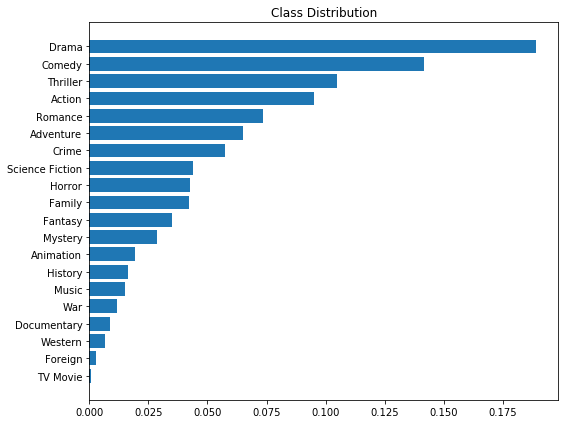

In [44]:
fig, ax = plt.subplots(figsize=(8,6))

list_class_counter = sorted(class_counter.items(), key=lambda x: x[1])
x_label, y_data = zip(*list_class_counter)
x_label = list(x_label)
y_data = np.array(y_data)
ind = np.arange(len(x_label))
ax.barh(ind, y_data/y_data.sum())
ax.set_yticks(ind)
ax.set_yticklabels(x_label);
ax.set_title("Class Distribution")
plt.tight_layout()
fig.savefig("class_distribution.eps")

Se puede notar que las clases están bastante desbalanceadas. Esto podría parecer un problema, pero la verdad no tenemos manera arreglarlo, ya que la muestra parece ser significativa y no hay nada que nos indique que esta no sea la manera en que se comportan los datos de los géneros de películas. Ideas como hacer resampling con métodos como bootstrap quedan descartados por el hecho de que anterarían la naturaleza de los datos, haciendo mas comunes géneros que no lo son, y los resultados se verían perjudicados. 

In [13]:
X = np.array(training)
y = np.array(output)

In [14]:
train_X = X[:int(len(X)*0.8)]
train_Y = y[:int(len(y)*0.8)]

test_X = X[int(len(X)*0.8):]
test_Y = y[int(len(y)*0.8):]

In [15]:
print(train_X.shape)
print(test_X.shape)

(3816, 14979)
(955, 14979)


In [31]:
def prepare_model(n):
    model = Sequential()
    model.add(Dense(n, input_dim=train_X.shape[1], kernel_initializer='uniform', activation="relu"))
    #model.add(Dropout(0.5))
    #model.add(Dense(1024, kernel_initializer='uniform', activation="relu"))
    #model.add(Dropout(0.1))
    #model.add(Dense(512, kernel_initializer='uniform', activation="relu"))
    model.add(Dense(train_Y.shape[1]))
    model.add(Activation("softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
model = prepare_model(1024)

## Entrenamiento del modelo.

In [18]:
model.fit(train_X, train_Y, epochs=10, batch_size=64, verbose=1, shuffle=True)

Epoch 1/10
3816/3816 [==============================] - 14s 4ms/step - loss: 6.4376 - acc: 0.3493
Epoch 2/10
3816/3816 [==============================] - 14s 4ms/step - loss: 4.5423 - acc: 0.4651
Epoch 3/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.7678 - acc: 0.4680
Epoch 4/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.7203 - acc: 0.4638
Epoch 5/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.6275 - acc: 0.4803
Epoch 6/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.4382 - acc: 0.4594
Epoch 7/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.3497 - acc: 0.4612
Epoch 8/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.3043 - acc: 0.4497
Epoch 9/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.2567 - acc: 0.4602
Epoch 10/10
3816/3816 [==============================] - 14s 4ms/step - loss: 3.2132 - acc: 0.4568


## Test del modelo.
Se procede a probar el modelo con los casos de prueba.

In [19]:
score=model.evaluate(test_X, test_Y, verbose=1)
print("\nLoss: %.3f \t Accuracy: %.3f" % (score[0], score[1]))

955/955 [==============================] - 1s 726us/step

Loss: 5.240 	 Accuracy: 0.390


## Probando distintas cantidades de neuronas

In [32]:
acc=[]
for i in range(8, 13):
    model = prepare_model(2**i)
    model.fit(train_X, train_Y, epochs=10, batch_size=64, verbose=1, shuffle=True)
    score=model.evaluate(test_X, test_Y, verbose=1)
    print("\nLoss: %.3f \t Accuracy: %.3f" % (score[0], score[1]))
    acc.append((2**i, score[1]))

Epoch 1/10
3816/3816 [==============================] - 4s 1ms/step - loss: 6.7181 - acc: 0.3215
Epoch 2/10
3816/3816 [==============================] - 4s 993us/step - loss: 5.1837 - acc: 0.4536
Epoch 3/10
3816/3816 [==============================] - 4s 994us/step - loss: 4.2419 - acc: 0.4680
Epoch 4/10
3816/3816 [==============================] - 4s 992us/step - loss: 3.7228 - acc: 0.4727
Epoch 5/10
3816/3816 [==============================] - 4s 987us/step - loss: 3.5302 - acc: 0.4725
Epoch 6/10
3816/3816 [==============================] - 4s 994us/step - loss: 3.4930 - acc: 0.4782
Epoch 7/10
3816/3816 [==============================] - 4s 987us/step - loss: 3.4397 - acc: 0.4486
Epoch 8/10
3816/3816 [==============================] - 4s 998us/step - loss: 3.3607 - acc: 0.4743
Epoch 9/10
3816/3816 [==============================] - 4s 995us/step - loss: 3.2992 - acc: 0.4513
Epoch 10/10
955/955 [==============================] - 0s 221us/step

Loss: 5.484 	 Accuracy: 0.372
Epoch 1/10


In [45]:
for n, a in acc:
    print("Neurons: %d, Accuracy %.4f" % (n , a))

Neurons: 256, Accuracy 0.3717
Neurons: 512, Accuracy 0.3832
Neurons: 1024, Accuracy 0.3780
Neurons: 2048, Accuracy 0.3948
Neurons: 4096, Accuracy 0.3885


Podemos apreciar que se obtuvo una precisión de casi un 39%, lo que es un avance, pero muy mejorable.

In [20]:
def clean_up_sentence(sentence):
    # tokenize the pattern
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word
    sentence_words = [stemmer.stem(word.lower()) for word in sentence_words]
    return sentence_words

def bow(sentence, words, show_details=False):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words
    bag = [0]*len(words)  
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
                    
    return(np.array(bag))

In [21]:
def predict(t, threshold=0.08):
    bag = bow(t, words)
    bag = np.array(bag).reshape(1, bag.shape[0])
    l = sorted(zip(classes, model.predict(bag)[0]), key=lambda x: x[1], reverse=True)
    return [i for i in l if i[1] > threshold]

## Test y Resultados.



In [43]:
test = ["A family goes out for vacations with their kids to enjoy the life", 
        "A bat have to save the world against superman",
       "An Alien arrived to my home and tried to kill me",
       "A haunted house is in front of my window",
       "A police man is killing someone"]

for t in test:
    print(t, predict(t, 0.1))
    print()

A family goes out for vacations with their kids to enjoy the life [('Comedy', 0.49139461), ('Drama', 0.24201618)]

A bat have to save the world against superman [('Adventure', 0.18571053), ('Science Fiction', 0.16517679), ('Thriller', 0.16131149), ('Action', 0.15941173)]

An Alien arrived to my home and tried to kill me [('Science Fiction', 0.15980904), ('Comedy', 0.1519575), ('Adventure', 0.10464507)]

A haunted house is in front of my window [('Drama', 0.19539094), ('Thriller', 0.19035596), ('Romance', 0.13468282), ('Comedy', 0.10071559)]

A police man is killing someone [('Thriller', 0.3323673), ('Crime', 0.18785048), ('Drama', 0.12651804), ('Action', 0.10783431)]



## Conclusiones

Se logró implementar una red neuronal usando los elementos aprendidos en la clase, y ciertas otras técnicas para manejar strings, tales como el stemming. Se lograron ver resultados concretos de la aplicación de esta red. Se aprecia que estas predicciones obtenidas parecen bastante acertadas, con bastante sentido. Sin embargo la precisión que se logró es aproximadamente de un 39%. 